In [11]:
# Import matplotlib for plotting purposes
import matplotlib
matplotlib.rcParams["text.usetex"] = True
import matplotlib.pyplot as plt

# Sometimes, we need Numpy, but wherever possible, we prefer torch.
import numpy as np

# Import PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Float (32 bit) or Double (64 bit) precision? Choose!
torch.set_default_dtype(torch.float32)#64)
torch.set_num_threads(4) # Use _maximally_ 4 CPU cores

# Material parameters
mu = 384.614  # Pa
lamda = 576.923  # Pa 

# Choose a device for major calculations (if there is a special GPU card, you usually want that).
# My GPU is not very performant for double precision, so I stay on CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)

# File path for saving the trained NN later.
# If only providing the file name (like here), the file will be generated in the same folder as the Python script
model_file = "CANN_small.torch"

## These parameters are usual hyperparameters of the NN and its training.
batch_size = 1024 # How many samples shall be presented to the NN, before running another optimizer step?
hidden_dim = 128 # How many neurons shall there be in the hidden layer(s)?
input_dim = 2 # Input dimension of the NN (i.e. how many neurons are in the input layer?)
output_dim = 1 # Some for output

epochs = 200 # Number of training iterations to be performed
lr = 1e-3 # Which learning rate is passed to the training algorithm?

## Choose a criterion to evaluate the results. Here, we choose Mean Square error.
## The term "loss" means about the same as "remaining error" or "residual".
criterion = nn.MSELoss(reduction="mean")

## Here, we create the training data. In this example, we draw samples within the sampling interval and then pass it to
## e.g. the sin function (choose other functions to experiment with this script)
min_I1 = 0.07999999999999996
max_I1 = 20.0

min_J = 0.03999999999999998
max_J = 10.0

# create uniformly distributed samples for I1 and J
# define the number of samples
n_samples = 1000

# create uniformly distributed samples for I1 and J
I1_uniform_samples = torch.linspace(min_I1, max_I1, n_samples)
J_uniform_samples = torch.linspace(min_J, max_J, n_samples)

# create all possible combinations of I1 and J
I1_uniform, J_uniform = torch.meshgrid(I1_uniform_samples, J_uniform_samples)

# flatten the tensors
I1_uniform = I1_uniform.flatten()
J_uniform = J_uniform.flatten()

# calculate the energy density for each combination
psi_uniform = lamda / 2 * (torch.log(J_uniform))**2 - mu * torch.log(J_uniform) + mu / 2 * (I1_uniform - 2)

# Input is I1 and J, output is psi, create train dataset
train_x_ori = torch.stack((I1_uniform, J_uniform), dim=1)
train_y_ori = psi_uniform

# save the mean and standard deviation of the training data for later use
train_x_mean = train_x_ori.mean(dim=0)
train_x_std = train_x_ori.std(dim=0)
train_y_mean = train_y_ori.mean(dim=0)
train_y_std = train_y_ori.std(dim=0)

train_x = (train_x_ori - train_x_mean) / train_x_std
train_y = (train_y_ori - train_y_mean) / train_y_std

# create test data with the same min und max values but different number of samples
n_samples = 100

# create uniformly distributed samples for I1 and J
I1_uniform_samples = torch.linspace(min_I1, max_I1, n_samples)
J_uniform_samples = torch.linspace(min_J, max_J, n_samples)

# create all possible combinations of I1 and J
I1_uniform, J_uniform = torch.meshgrid(I1_uniform_samples, J_uniform_samples)

# flatten the tensors
I1_uniform = I1_uniform.flatten()
J_uniform = J_uniform.flatten()

# standard deviation and mean of the test data


# calculate the energy density for each combination
psi_uniform = lamda / 2 * (torch.log(J_uniform))**2 - mu * torch.log(J_uniform) + mu / 2 * (I1_uniform - 2)

# Input is I1 and J, output is psi, create test dataset
test_x = torch.stack((I1_uniform, J_uniform), dim=1)
test_y = psi_uniform

test_x = (test_x - train_x_mean) / train_x_std
test_y = (test_y - train_y_mean) / train_y_std


# print all the std and mean values
print(f"train_x_mean= {train_x_mean}")
print(f"train_x_std= {train_x_std}")
print(f"train_y_mean= {train_y_mean}")
print(f"train_y_std= {train_y_std}")
print(f"test_x_mean= {test_x.mean(dim=0)}")
print(f"test_x_std= {test_x.std(dim=0)}")
print(f"test_y_mean= {test_y.mean(dim=0)}")
print(f"test_y_std= {test_y.std(dim=0)}")


## We want a DataLoader to handle batching and shuffling of the training data for us.
## The DataLoader needs a TensorDataset, hence we create one from the Training data.
train_data = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=False)


## This class creates the actual Neural Network.
class MLNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLNet, self).__init__()

        # First layer: half linear, half quadratic
        self.layer1_linear = nn.Linear(input_dim, hidden_dim // 2)
        self.layer1_quadratic = nn.Linear(input_dim, hidden_dim // 2)

        # Second layer: half exponential, half linear
        self.layer2_linear = nn.Linear(hidden_dim, hidden_dim // 2)
        self.layer2_exponential = nn.Linear(hidden_dim, hidden_dim // 2)

        # Final layer to combine outputs
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # First layer transformations
        linear_out = self.layer1_linear(x)
        quadratic_out = torch.pow(self.layer1_quadratic(x), 2)
        combined1 = torch.cat((linear_out, quadratic_out), dim=1)

        # Second layer transformations
        linear_out2 = self.layer2_linear(combined1)
        exp_out = torch.exp(self.layer2_exponential(combined1))
        combined2 = torch.cat((linear_out2, exp_out), dim=1)

        # Final output layer
        output = self.output_layer(combined2)
        return output

## This function performs a test run with the NN.
## It takes the NN model and the test data, passes the test inputs through the network and
## compares it with the target values = test outputs = targets
## and based on that calculates the loss value
def evaluate(model, test_x, test_y):
    ## For testing, we don't need the autograd feature/ protocol of all calculation steps
    ## So, save some time and disable grad tracking.
    with torch.no_grad():
        model.eval() ## Set the NN model into evaluation mode
        outputs = [] ## Create empty lists to store the results
        targets = []
        testlosses = []

        out = model(test_x.to(device)) ## Call the model, i.e. perform the actual inference

        ## Move the output quantities to the CPU, detach them from the tensor operation book-keeping and convert them to numpy arrays/ vectors.
        ## This is all necessary for plotting
        outputs.append(out.cpu().detach().numpy())
        targets.append(test_y.cpu().detach().numpy())
        testlosses.append(criterion(out.squeeze(), test_y.to(device)).item())

    ## Now return that in form of a triple of variables
    return outputs, targets, testlosses

## This calls the evaluate function and takes care of the plotting.
def eval_and_plot(model):
        ## matplotlib tries to be similar to the plot functions of matlab  (admittedly, the commands have to begin with "plt.", but the rest
        ## is quite similar.)
        #plt.subplot(1, 1, 1)

        ## Call the network on the test data
        net_outputs_test, targets_test, testlosses = evaluate(model, test_x, test_y)
        # Plot the targets first in blue (which means to plot the actual function over the whole test interval)
        #plt.scatter()#, "-x", color="b", label="Target")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(test_x[:,0], test_x[:,1], targets_test, marker='x', c='skyblue', s=60)

        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()

        ## Call the network on the training data
        net_outputs_train, targets_train, testlosses = evaluate(model, train_x, train_y)
        ## First, plot the targets in red, i.e. plot the training data set
        ax.scatter(train_x[:,0], train_x[:,1], targets_train[0], marker='^', c='red', s=60)

        ## Now, plot the output of the NN on the whole test interval in green
        ## This allows us to see how the NN performs for interpolation as well as for extrapolation
        ax.scatter(test_x[:,0], test_x[:,1], net_outputs_test[0], marker='o', c='green', s=60)

        ## All plotting is done, open the plot window
        plt.show()


## That function takes care of the whole training
def train(train_loader, learn_rate, EPOCHS):  # 10):
    # Instantiate the NN
    model = MLNet(input_dim, hidden_dim, output_dim)
    model.to(device) # and move it to the "device" (in case we use a GPU)
    ## Choose an optimizer.
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    # We want to keep track of the losses averaged over each epoch, to plot them
    avg_losses = torch.zeros(EPOCHS)

    ## In the end, epoch is just another word for "training iteration", so we have a simple for loop.
    for epoch in range(EPOCHS):
        model.train() # Set the model into train mode
        avg_loss = 0. # initializations

        ## DataLoader is iterable so that this for-loop loops over the batches of the training data set
        ## and the DataLoader gives us readily paired combinations of training inputs and targets (which are called x and label, here).
        for x, label in train_loader:
            model.zero_grad() # Important: reset the gradients of the NN before passing the training inputs.
            # Otherwise, we would accumulate the gradient information which might ruin the results
            # or simply run into PyTorch exceptions

            ## Now, we can call the model on the training inputs.
            out = model(x.to(device))
            loss = criterion(out.squeeze(), label.to(device)) # Now, calculate the loss value

            ## Here, the whole magic happens...
            loss.backward()
            optimizer.step()

            ## For the plot at the end, save the loss values
            avg_loss += loss.item()

        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss / len(train_loader)))
        ## It's an average loss, so divide by the number of samples/ size of the training data set
        avg_losses[epoch] = avg_loss / len(train_loader)

        ## This plots the loss curve
    plt.figure(figsize=(12, 8))
    plt.plot(avg_losses, "x-")
    plt.title("Train loss (MSE, reduction=mean, averaged over epoch)")
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.grid(visible=True, which='both', axis='both')
    plt.show()
        
    ## Now save the trained model with all its properties to the model_file
    torch.save(model, model_file)
    ## And return the model in case we want to use it for other tasks
    return model

model = train(train_loader, lr, epochs)

Using cpu device
train_x_mean= tensor([10.0400,  5.0200])
train_x_std= tensor([5.7562, 2.8781])
train_y_mean= 1798.107421875
train_y_std= 1174.586181640625
test_x_mean= tensor([-2.4414e-08,  1.6479e-07])
test_x_std= tensor([1.0091, 1.0091])
test_y_mean= 0.020148921757936478
test_y_std= 1.0429712533950806


/Users/chexuanyou/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_581jc0ddx6/croot/pytorch-select_1730848714937/work/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0/200 Done, Total Loss: 0.023781247008753944
Epoch 1/200 Done, Total Loss: 0.006826739700343327
Epoch 2/200 Done, Total Loss: 0.00499798873205409


KeyboardInterrupt: 

In [1]:
# plot the difference between Neural Network and analytical solution
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["text.usetex"] = True

## Here, we create the test data.
# Smaller dataset and include larger area outside the training data
min_I1 = 0.07999999999999996
max_I1 = 20.0

min_J = 0.03999999999999998
max_J = 10.0

# create uniformly distributed samples for I1 and J
# define the number of samples
n_samples = 30

# create uniformly distributed samples for I1 and J
I1_uniform_samples = torch.linspace(min_I1, max_I1, n_samples)
J_uniform_samples = torch.linspace(min_J, max_J, n_samples)

# create all possible combinations of I1 and J
I1_uniform, J_uniform = torch.meshgrid(I1_uniform_samples, J_uniform_samples)

# flatten the tensors
I1_uniform = I1_uniform.flatten()
J_uniform = J_uniform.flatten()

# calculate the energy density for each combination
psi_uniform = lamda / 2 * (torch.log(J_uniform))**2 - mu * torch.log(J_uniform) + mu / 2 * (I1_uniform - 2)

# Input is I1 and J, output is psi, create test dataset
test_x = torch.stack((I1_uniform, J_uniform), dim=1)
test_y = psi_uniform

# normalize the test data
test_x_norm = (test_x - train_x_mean) / train_x_std
test_y_norm = (test_y - train_y_mean) / train_y_std

# Call the network on the test data
net_outputs_test, targets_test, testlosses = evaluate(model, test_x_norm, test_y_norm)

# inverse the normalization of the net_outputs_test
net_outputs_test = net_outputs_test * train_y_std.detach().numpy() + train_y_mean.detach().numpy()

# calculate the target with the analytical solution
psi_target = lamda / 2 * (torch.log(test_x[:, 1]))**2 - mu * torch.log(test_x[:, 1]) + mu / 2 * (test_x[:, 0] - 2)

# plot the difference between Neural Network and analytical solution in subplot right and left
fig, axs = plt.subplots(1,3, figsize=(8*2, 10))  # create figure and axes

# plot the analytical solution
sc = axs[0].scatter(test_x[:, 0].detach().numpy(), test_x[:, 1].detach().numpy(), c=psi_target.detach().numpy(), cmap='viridis', vmin=psi_target.min().item(), vmax=psi_target.max().item())
axs[0].set_title("Analytical solution")
axs[0].set_xlabel("I1")
axs[0].set_ylabel("J")
fig.colorbar(sc, ax=axs[0], label='Helmholtz Free Energy Density $\Psi$')

# plot the Neural Network solution
sc = axs[1].scatter(test_x[:, 0].detach().numpy(), test_x[:, 1].detach().numpy(), c=net_outputs_test, cmap='viridis', vmin=psi_target.min().item(), vmax=psi_target.max().item())
axs[1].set_title("Neural Network solution")
axs[1].set_xlabel("I1")
axs[1].set_ylabel("J")
fig.colorbar(sc, ax=axs[1], label='Helmholtz Free Energy Density $\Psi$')

# plot the difference between Neural Network and analytical solution
# color is absolute difference
dif = np.abs(net_outputs_test.flatten() - psi_target.detach().numpy())
sc = axs[2].scatter(test_x[:, 0].detach().numpy(), test_x[:, 1].detach().numpy(), c=dif, vmax=dif.max(), vmin=dif.min(), cmap='Reds')
axs[2].set_title("Difference between Neural Network and Analytical solution")
axs[2].set_xlabel("I1")
axs[2].set_ylabel("J")
fig.colorbar(sc, ax=axs[2], label='Absolute difference')


plt.tight_layout()  # adjust layout
plt.show()

NameError: name 'torch' is not defined

Using device: cpu
Epoch [1/200]  train_loss=0.18280  val_loss=0.07703  lr=1.00e-03
Epoch [2/200]  train_loss=0.06774  val_loss=0.05957  lr=1.00e-03
Epoch [3/200]  train_loss=0.05120  val_loss=0.04303  lr=1.00e-03
Epoch [4/200]  train_loss=0.03458  val_loss=0.03098  lr=1.00e-03
Epoch [5/200]  train_loss=0.02534  val_loss=0.02460  lr=1.00e-03
Epoch [6/200]  train_loss=0.02190  val_loss=0.02170  lr=1.00e-03
Epoch [7/200]  train_loss=0.02043  val_loss=0.01904  lr=1.00e-03
Epoch [8/200]  train_loss=0.01691  val_loss=0.01732  lr=1.00e-03
Epoch [9/200]  train_loss=0.01614  val_loss=0.02060  lr=1.00e-03
Epoch [10/200]  train_loss=0.01647  val_loss=0.01788  lr=1.00e-03
Epoch [11/200]  train_loss=0.01480  val_loss=0.01356  lr=1.00e-03
Epoch [12/200]  train_loss=0.01218  val_loss=0.01148  lr=1.00e-03
Epoch [13/200]  train_loss=0.01093  val_loss=0.01431  lr=1.00e-03
Epoch [14/200]  train_loss=0.01137  val_loss=0.01017  lr=1.00e-03
Epoch [15/200]  train_loss=0.01016  val_loss=0.01176  lr=1.00e-03
E

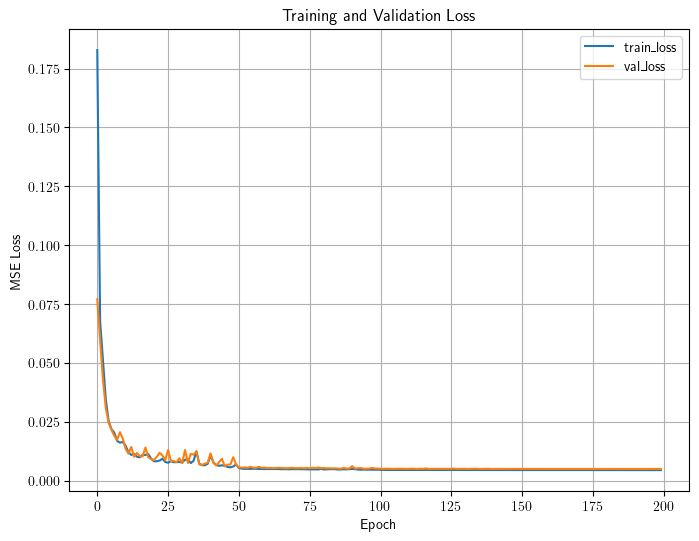

Model saved to CANN_mid4.torch, best val_loss=0.004965


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

# -----------------------------
# 1. 设置一些超参数
# -----------------------------
torch.set_default_dtype(torch.float32)
torch.set_num_threads(4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

mu = 384.614
lamda = 576.923

# 拟合的 (I1, J) 范围
min_I1, max_I1 = 0.08, 20.0
min_J,  max_J  = 0.04, 10.0

# 训练数据大小 (随机采样数量)
n_samples = 30000  # 3万，可以视情况调整

batch_size = 1024
hidden_dim = 128
input_dim = 2
output_dim = 1
epochs = 200  # 训练 epoch 增加到200试试看
lr = 1e-3     # 初始学习率改小一点

# ------------------------------------------------------
# 2. 生成数据 (随机采样) + 计算解析的 psi + 拆分 train/val
# ------------------------------------------------------
torch.manual_seed(42)  # 为了复现结果，固定随机种子
I1_rand = torch.rand(n_samples)*(max_I1 - min_I1) + min_I1
J_rand  = torch.rand(n_samples)*(max_J  - min_J)  + min_J

# 解析公式
psi_rand = lamda/2 * (torch.log(J_rand))**2 - mu*torch.log(J_rand) + mu/2*(I1_rand - 2)

# 合并输入
x_all = torch.stack([I1_rand, J_rand], dim=1)
y_all = psi_rand.view(-1, 1)

# 先随机拆分 train:val=8:2
train_size = int(0.8 * n_samples)
val_size   = n_samples - train_size
# 下面这一步不会打乱 x_all,y_all，如果想打乱可先 permute
dataset_all = TensorDataset(x_all, y_all)
train_dataset, val_dataset = random_split(dataset_all, [train_size, val_size])

# 计算 train_mean,train_std (只用训练集做统计)
train_x_ori = train_dataset[:][0]  # 取出训练集的 x
train_y_ori = train_dataset[:][1]

train_x_mean = train_x_ori.mean(dim=0)
train_x_std  = train_x_ori.std(dim=0)
train_y_mean = train_y_ori.mean(dim=0)
train_y_std  = train_y_ori.std(dim=0)

# 避免std为0
train_x_std[train_x_std==0] = 1e-8
train_y_std[train_y_std==0] = 1e-8

def normalize_x(x):
    return (x - train_x_mean)/train_x_std
def normalize_y(y):
    return (y - train_y_mean)/train_y_std

def denormalize_y(y_norm):
    return y_norm*train_y_std + train_y_mean

# 对train,val做归一化
train_x_norm = normalize_x(train_x_ori)
train_y_norm = normalize_y(train_y_ori)

val_x_ori = val_dataset[:][0]
val_y_ori = val_dataset[:][1]
val_x_norm = normalize_x(val_x_ori)
val_y_norm = normalize_y(val_y_ori)

# DataLoader
train_data = TensorDataset(train_x_norm, train_y_norm)
val_data   = TensorDataset(val_x_norm, val_y_norm)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)

# ----------------------------------------
# 3. 定义一个更常规的MLP网络 (SiLU激活)
# ----------------------------------------
## This class creates the actual Neural Network.
class MLNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLNet, self).__init__()

        # First layer: half linear, half quadratic
        self.layer1_linear = nn.Linear(input_dim, hidden_dim // 2)
        self.layer1_quadratic = nn.Linear(input_dim, hidden_dim // 2)

        # Second layer: half exponential, half linear
        self.layer2_linear = nn.Linear(hidden_dim, hidden_dim // 2)
        self.layer2_exponential = nn.Linear(hidden_dim, hidden_dim // 2)

        # Final layer to combine outputs
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # First layer transformations
        linear_out = self.layer1_linear(x)
        quadratic_out = torch.pow(self.layer1_quadratic(x), 2)
        combined1 = torch.cat((linear_out, quadratic_out), dim=1)

        # Second layer transformations
        linear_out2 = self.layer2_linear(combined1)
        exp_out = torch.exp(self.layer2_exponential(combined1))
        combined2 = torch.cat((linear_out2, exp_out), dim=1)

        # Final output layer
        output = self.output_layer(combined2)
        return output

# -----------------------------
# 4. 训练循环 + 验证 + 调度器
# -----------------------------
def train_model(epochs=epochs, lr=lr):
    model = MLNet(input_dim, hidden_dim, output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # 可选的 StepLR，每50 epoch衰减lr到0.1倍
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    criterion = nn.MSELoss(reduction='mean')
    best_val_loss = 1e9
    best_model_state = None

    train_loss_history = []
    val_loss_history   = []

    for ep in range(epochs):
        # 训练一个 epoch
        model.train()
        running_loss = 0.0
        for bx, by in train_loader:
            bx = bx.to(device)
            by = by.to(device)
            optimizer.zero_grad()
            out = model(bx)
            loss = criterion(out, by)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*bx.size(0)  # 累加

        # 计算平均 train_loss
        train_loss = running_loss/len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # 验证
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            for vx, vy in val_loader:
                vx = vx.to(device)
                vy = vy.to(device)
                vout = model(vx)
                vloss = criterion(vout, vy)
                val_running_loss += vloss.item()*vx.size(0)
            val_loss = val_running_loss/len(val_loader.dataset)
            val_loss_history.append(val_loss)

        # 更新学习率
        scheduler.step()

        # Early Stopping/保存最优模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        print(f"Epoch [{ep+1}/{epochs}]  train_loss={train_loss:.5f}  val_loss={val_loss:.5f}  lr={scheduler.get_last_lr()[0]:.2e}")

    # 恢复最优模型权重
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 画训练/验证误差曲线
    plt.figure(figsize=(8,6))
    plt.plot(train_loss_history, label='train_loss')
    plt.plot(val_loss_history,   label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    model_file = "CANN_mid4.torch"
    # 保存最优模型
    torch.save({
        'model_state': model.state_dict(),
        'x_mean': train_x_mean,
        'x_std' : train_x_std,
        'y_mean': train_y_mean,
        'y_std' : train_y_std
    }, model_file)
    print(f"Model saved to {model_file}, best val_loss={best_val_loss:.6f}")

    return model

if __name__ == "__main__":
    model = train_model(epochs=epochs, lr=lr)
